# `018` Reinforcement learning

Requirements: 005 Multilayer perceptron, 015 Residual connections

Neural networks are universal function approximators. And because of being just functions, they take a fixed input and produce a fixed output. However, in many real-world problems this setup is not enough. Let's say we wanted to train a neural network to play snake. To be able to apply the network over multiple, iterative steps in a game, we could say that the input is the current state of the game, and the output is the next action to take (as a probability distribution over all possible actions). If we did that, how could we train the network? What would be our loss function?

## The environment

The answer is reinforcement learning. In this training paradigm, we define a reward function that gives a scalar value which tells how good or bad the network did. Then, the network is trained to maximize that reward over time. The definition of the initial state, how actions change states, and what output is expected from the network are all part of the environment definition. Let's define an environment for the snake game. We will use the following setup:

The board is a 5x5 grid in which 0 means it's empty, 1 is the food, 2 is the snake's head, and [3, 4, 5, 6] are the snake's body. Why using multiple numbers for the body? So that we can represent the direction in which this body part is looking at. This way, if we have a board like this:

```
···
○▼●
·▶▲
```

Where the black circle is the head, the white cirle is the food, and the arrows are body parts looking towards the head, you know you can go left without dieing, because the tail is there and the moment you move it will also move.

The actions are 0 for up, 1 for right, 2 for down, and 3 for left. If the snake hits a wall or itself, the game is over with reward `-1`. If the snake eats the food, it grows by one and the reward is `1`. Otherwise, the reward is `0`.

This environment is implemented as a class with methods `reset(self) -> board` and `step(action) -> board, reward, done`. This style is similar to OpenAI's gym, and it's the most common way to define environments in RL.

In [1]:
from collections import deque
from matplotlib import pyplot as plt
from random import randint
from time import time
import torch

# device = torch.device('cuda' if torch.backends.cudnn.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
class SnakeEnv:
	C_EMPTY, C_FOOD, C_HEAD, C_BODY_UP, C_BODY_RIGHT, C_BODY_DOWN, C_BODY_LEFT = 0, 1, 2, 3, 4, 5, 6
	D_UP, D_RIGHT, D_DOWN, D_LEFT = 0, 1, 2, 3
	R_LOSE, R_FOOD, R_WIN, R_OTHER = -1, 1, 1, 0

	def __init__(self, size=5):
		self.size = size

	def reset(self):
		self.board = torch.zeros((self.size, self.size), dtype=torch.int, device=device)
		self.body = deque([(randint(0, self.size - 1), randint(0, self.size - 1))])
		self.board[*self.body[0]] = SnakeEnv.C_HEAD
		self._place_food()
		return self.board

	def step(self, action):
		if action == SnakeEnv.D_UP: new_head = (self.body[0][0] - 1, self.body[0][1])
		elif action == SnakeEnv.D_RIGHT: new_head = (self.body[0][0], self.body[0][1] + 1)
		elif action == SnakeEnv.D_DOWN: new_head = (self.body[0][0] + 1, self.body[0][1])
		elif action == SnakeEnv.D_LEFT: new_head = (self.body[0][0], self.body[0][1] - 1)
		if not (0 <= new_head[0] < self.size and 0 <= new_head[1] < self.size) or self.board[*new_head] > SnakeEnv.C_HEAD and new_head != self.body[-1]:
			reward, done = SnakeEnv.R_LOSE, True
		else:
			self.body.appendleft(new_head)
			if new_head == self.food:
				if len(self.body) == self.size * self.size:
					reward, done = SnakeEnv.R_WIN, True
				else:
					reward, done = SnakeEnv.R_FOOD, False
					self._place_food()
			else:
				self.board[*self.body[-1]] = SnakeEnv.C_EMPTY
				self.body.pop()
				reward, done = SnakeEnv.R_OTHER, False
			self.board[*new_head] = SnakeEnv.C_HEAD
			if len(self.body) > 1:
				self.board[*self.body[1]] = [SnakeEnv.C_BODY_UP, SnakeEnv.C_BODY_RIGHT, SnakeEnv.C_BODY_DOWN, SnakeEnv.C_BODY_LEFT][action]
		return self.board, reward, done

	def _place_food(self):
		while True:
			food = (randint(0, self.size - 1), randint(0, self.size - 1))
			if self.board[*food] == SnakeEnv.C_EMPTY: break
		self.food = food
		self.board[*self.food] = SnakeEnv.C_FOOD

env = SnakeEnv()

Now let's also define a way to draw boards so that we can visualize the game.

In [3]:
def draw_board(board):
	print('\n'.join(''.join(
		'·○●▲▶▼◀'[cell]
		for cell in row
	) for row in board))

draw_board(env.reset())

···●·
·····
·····
○····
·····


## The agent

Once our environment is defined, we can start training an agent to play it. The agent is a neural network that takes the board as input and outputs a probability distribution over the actions. We will use a very simple network in which the input is one-hot encoded (so that the 5x5 board becomes 5x5x7, one per class), then flattened and mapped to the hidden size, and then passed through a few hidden layers with residual connections. The output is the expected reward that will be obtained from each action, so that we can train it to adjust to the real rewards.

In [4]:
class Agent(torch.nn.Module):
	NUM_CLASSES = 7
	def __init__(self, board_size=5, hidden_size=27, depth=5):
		super().__init__()
		self.register_buffer('diagonal', torch.eye(Agent.NUM_CLASSES, device=device))
		self.input = torch.nn.Linear(board_size**2 * Agent.NUM_CLASSES, hidden_size)
		self.hidden = []
		for _ in range(depth):
			self.hidden.append(torch.nn.Sequential(
				torch.nn.Linear(hidden_size, hidden_size),
				torch.nn.GELU(),
				torch.nn.LayerNorm(hidden_size)
			))
		self.hidden = torch.nn.ModuleList(self.hidden)
		self.output = torch.nn.Linear(hidden_size, 4, bias=False)

	def forward(self, x):
		x = self.diagonal[x.flatten(-2)].flatten(-2)
		x = self.input(x).relu()
		for layer in self.hidden:
			x = x + layer(x)
		x = self.output(x)
		return x

ai = Agent().to(device)
print(f'Agent has {sum(p.numel() for p in ai.parameters()):,} parameters')

Agent has 8,910 parameters


# Training

First, we have to define a loop to play episodes. But there is something important to note. If we just train the network to think of the reward, it will always take the most immediate rewards. If the snake needs to move 3 times to reach the food, it won't be able to see past the first move. To solve this, we use a discount factor. This is done in the following way:

Let's say our agent plays for 10 steps before hitting a wall, and just eats food once.

In [5]:
rewards = [0, 0, 0, 0, 1, 0, 0, 0, 0, -1]

We want to make each step have some impact from the future, so we can define a parameter called `discount factor`, or just `gamma`. This parameter is a number between 0 and 1 that tells how much we should care about future rewards. If we say `gamma = 0.5`, then the second-to-last step would receive `0.5 * -1` from the last step, and the third-to-last step would receive `0.5 * 0.5 * -1` from the second-to-last step, and so on. This way, the agent will learn to take actions that lead to future rewards, not just immediate ones. This is called the `discounted reward`.

0.06, 0.12, 0.24, 0.48, 0.97, -0.06, -0.12, -0.25, -0.50, -1.00


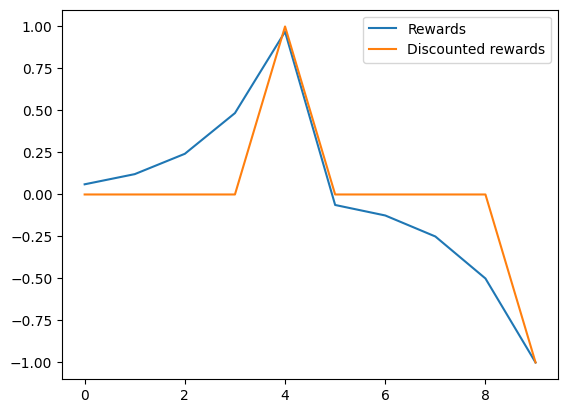

In [6]:
discounted_rewards = rewards.copy()
for i in range(len(rewards) - 2, -1, -1):
	rewards[i] += rewards[i + 1] * 0.5
print(', '.join('%.2f' % r for r in rewards))

plt.plot(rewards, label='Rewards')
plt.plot(discounted_rewards, label='Discounted rewards')
plt.legend();

So now, let's create a loop that records a full game (called episode), and then discounts its rewards. But there is one more parameter we should think about: the exploration rate, or epsilon. Simply put, epsilon is a $[0, 1]$ parameter that represents the probability of just taking a random action.

Imagine that we had a perfect agent that always took good actions. If that was the case, we would never train over different actions, and the network might miss even better actions. This is why we need to just take a random action with a certain probability.

In [7]:
def play_episode(env, agent, eps=.3, gamma=.9, max_steps=100):
	boards, actions, rewards = [], [], []
	board = env.reset()
	steps = 0
	while True:
		boards.append(board.clone())
		if torch.rand(()) < eps:
			action = torch.randint(0, 4, ())
		else:
			action = agent(board).argmax().item()
		actions.append(action)
		board, reward, done = env.step(action)
		rewards.append(reward)
		steps += 1
		if done or steps == max_steps: break
	for i in range(len(rewards) - 2, -1, -1):
		rewards[i] += gamma * rewards[i + 1]
	return torch.stack(boards), torch.tensor(actions, device=device), torch.tensor(rewards, dtype=torch.float, device=device)

The combination of discounted rewards and epsilon have profound implications in the way we train the network. In the snake game, having non-zero epsilon means that sometimes our agent can just decide to hit a wall. Hence, the best policy will try to avoid getting too close to the walls, even if that's not necessarily the best choice. However, if the epsilon is too low, the agent will never explore new actions, and will just take the same actions over and over again.

Usually, we start our training with a high epsilon (in the snake case 0.3 is a good value), and we decrease it over time. Once the network is fully trained, we can set epsilon to 0 and train for a few more steps to make it slightly better.

Since this whole approach is very sample-hungry, we need to have a way to record past matches and learn from them without having to record new ones all the time. This is done by storing the past matches in a replay buffer, and then sampling from it to train the network.

In [8]:
class ReplayBuffer:
	def __init__(self, board_size=5, length=10**5):
		self.boards = torch.zeros((length, board_size, board_size), dtype=torch.int, device=device)
		self.actions = torch.zeros((length,), dtype=torch.int, device=device)
		self.rewards = torch.zeros((length,), dtype=torch.float, device=device)
		self.length = length
		self.next_ix = 0

	def append(self, boards, actions, rewards):
		batch_size = len(boards)
		last_ix = self.next_ix + batch_size
		if last_ix <= self.length:
			self.boards[self.next_ix:last_ix], self.actions[self.next_ix:last_ix], self.rewards[self.next_ix:last_ix] = boards, actions, rewards
			self.next_ix = last_ix % self.length
		else:
			fitting = self.length - self.next_ix
			self.boards[-fitting:], self.actions[-fitting:], self.rewards[-fitting:] = boards[:fitting], actions[:fitting], rewards[:fitting]
			self.next_ix = 0
			self.append(boards[fitting:], actions[fitting:], rewards[fitting:])
	
	def sample(self, batch_size):
		ix = torch.randint(0, self.length, (min(batch_size, self.next_ix),))
		return self.boards[ix], self.actions[ix], self.rewards[ix]

buffer = ReplayBuffer()

Now, we will define the training environment. On every iteration, we will play a full snake game and store the board states and the rewards. Then, we will train the agent to predict the rewards from the board states. Rewards are discounted to factor in the future consequences of the actions.

In [9]:
def train(env, agent, episodes=100_000, batch_size=1000, lr=2e-5, max_eps=.3, gamma=.9):
	optimizer = torch.optim.AdamW(agent.parameters(), lr=lr)
	losses, avg_rewards = [], []
	start = time()
	for e in range(episodes):
		progress = (e + 1) / episodes
		# record experiences
		agent.eval()
		buffer.append(*play_episode(env, agent, eps=max_eps * (1 - progress), gamma=gamma))
		# update agent
		agent.train()
		boards, actions, rewards = buffer.sample(batch_size)
		predicted_rewards = agent(boards)[torch.arange(len(boards)), actions]
		loss = torch.nn.functional.mse_loss(predicted_rewards, rewards)
		optimizer.zero_grad()
		loss.backward()
		# stats
		losses.append(loss.item())
		avg_rewards.append(rewards.mean().item())
		optimizer.step()
		if e % (episodes // 10) == 0 and e > 0 or e == 50 or e == episodes - 1:
			remaining = (time() - start) * (1 - progress) / progress
			print(f'[{100 * progress:5.2f}%, remaining {remaining // 60:02.0f}:{remaining % 60:02.0f}] loss {torch.tensor(losses[-1000:]).mean():.6f}, avg reward {torch.tensor(avg_rewards[-1000:]).mean():.6f}')
	return losses, avg_rewards

start = time()
print('Training with linearly decreasing epsilon')
losses, avg_rewards = train(env, ai)
print('Training with epsilon=0')
losses2, avg_rewards2 = train(env, ai, max_eps=0)
losses = losses + losses2
avg_rewards = avg_rewards + avg_rewards2
print(f'Total training time: {time() - start:.0f}s, average loss {torch.tensor(losses[-1000:]).mean():.6f}, average reward {torch.tensor(avg_rewards[-1000:]).mean():.6f}')

Training with linearly decreasing epsilon
[ 0.05%, remaining 06:47] loss 0.048841, avg reward -0.001023
[10.00%, remaining 13:58] loss 0.153644, avg reward 0.021303
[20.00%, remaining 10:58] loss 0.328203, avg reward 0.218962
[30.00%, remaining 08:56] loss 0.500227, avg reward 0.498540
[40.00%, remaining 07:24] loss 0.556673, avg reward 0.619131
[50.00%, remaining 06:05] loss 0.616253, avg reward 0.753243
[60.00%, remaining 04:52] loss 0.661337, avg reward 0.895877
[70.00%, remaining 03:42] loss 0.730546, avg reward 1.032152
[80.00%, remaining 02:31] loss 0.731523, avg reward 1.200820
[90.00%, remaining 01:17] loss 0.677960, avg reward 1.377509
[100.00%, remaining 00:00] loss 0.519728, avg reward 1.614371
Training with epsilon=0
[ 0.05%, remaining 21:17] loss 0.524494, avg reward 1.618822
[10.00%, remaining 19:16] loss 0.482675, avg reward 1.700551
[20.00%, remaining 17:33] loss 0.496328, avg reward 1.721030
[30.00%, remaining 14:54] loss 0.485733, avg reward 1.745867
[40.00%, remainin

Now let's plot the training process.

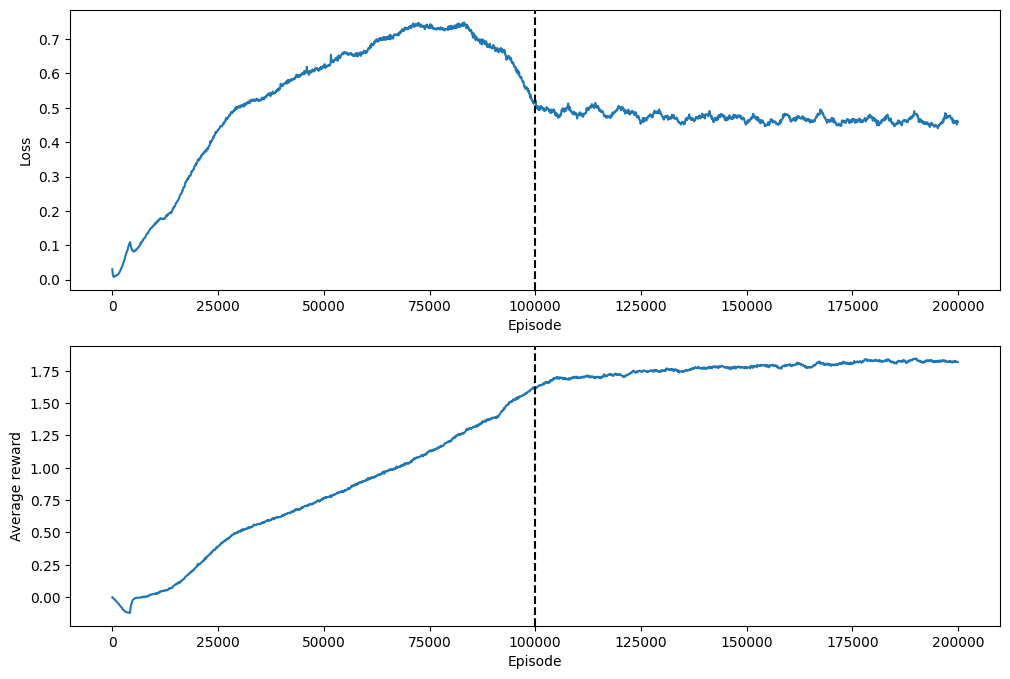

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.plot(range(0, len(losses), 100), torch.tensor(losses).view(-1, 100).mean(1))
plt.axvline(x=10**5, color='k', linestyle='--')
plt.subplot(2, 1, 2)
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.plot(range(0, len(losses), 100), torch.tensor(avg_rewards).view(-1, 100).mean(1))
plt.axvline(x=10**5, color='k', linestyle='--');

Finally, let's create a video of the agent playing the game.

In [11]:
from cv2 import VideoWriter, VideoWriter_fourcc  # pip install opencv-python opencv-contrib-python

boards, actions, rewards = play_episode(env, ai, eps=0, gamma=0, max_steps=1000)
palette = torch.tensor([[0, 0, 0], [0, 255, 0], [255, 255, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0]], dtype=torch.uint8)
video = palette[boards]
scaling_factor = video.shape[-2] * 40
video = torch.nn.functional.interpolate(
    video.permute(0, 3, 1, 2).float(),
    size=(scaling_factor, scaling_factor),
    mode='nearest'
).byte().permute(0, 2, 3, 1).numpy()
fourcc = VideoWriter_fourcc(*'mp4v')
out = VideoWriter('snake_animation.mp4', fourcc, 10, (scaling_factor, scaling_factor))
for frame in video: out.write(frame)
out.release()
# now open it with a video player:
from subprocess import run
run(['open', 'snake_animation.mp4'])

CompletedProcess(args=['open', 'snake_animation.mp4'], returncode=0)

Note that in this notebook, we have studied how to create a neural network to predict the rewards in a reinforcement learning environment. However, we haven't adjusted any hyperparameter because the board was just 5x5. As you increase the board size, you will need to explore different hyperparameters to make the network converge, such as:

* Hidden size and depth
* Learning rate
* Using argmax or multinomial sampling
* Discount factor (gamma)
* Exploration randomness (epsilon)
* Multiple reward configurations